In [ ]:
from google.colab import drive
 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [ ]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from sklearn.utils import shuffle
from keras.preprocessing import sequence# Our dictionary will contain only of the top 7000 words appearing most frequently

In [ ]:
TRAIN_CSV_PATH = r'/content/drive/MyDrive/Group_13/Text Proccesing/DATASET_10/TRAIN/multimodal_train.csv'
TEST_CSV_PATH = r'/content/drive/MyDrive/Group_13/Text Proccesing/DATASET_10/TEST/multimodal_test.csv'
VALIDATE_CSV_PATH = r'/content/drive/MyDrive/Group_13/Text Proccesing/DATASET_10/VALIDATE/multimodal_validate.csv'

In [ ]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
val_df = pd.read_csv(VALIDATE_CSV_PATH)

In [ ]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)
val_df = shuffle(val_df)

In [ ]:
train_df.head()

,Unnamed: 0,Unnamed: 0.1,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
33199,536760,536760,SonofBeast,iams good for life,1.502895e+09,NaN,True,dlpdomw,http://i.imgur.com/F9omED1.jpg,6u11p0,NaN,59,psbattle_artwork,"Iams, Good For Life",NaN,0,2,4
20170,350840,350840,Slingy17,this small tree is hugging the big one,1.558904e+09,i.redd.it,True,btd3qn,https://preview.redd.it/pytk97kmcm031.jpg?widt...,NaN,2.0,7,mildlyinteresting,This small tree is hugging the big one,0.78,1,0,0
22115,355785,355785,chubby-coon,man sits in the forever alone booth,1.374896e+09,i.imgur.com,True,1j53vv,https://external-preview.redd.it/jlTZxoh5u7ppy...,NaN,5.0,2,photoshopbattles,Man sits in the forever alone booth,0.59,1,0,0
39905,523274,523274,aresef,corner store customers saddened by sight of fr...,1.558714e+09,politics.theonion.com,True,bsiobr,https://external-preview.redd.it/wyXir5NXPohB-...,NaN,1.0,40,theonion,Corner Store Customers Saddened By Sight Of Fr...,0.95,0,2,1
29684,277656,277656,JournalofFailure,concept art for pixars cars,1.550367e+09,i.redd.it,True,arfip5,https://preview.redd.it/rvd2yqu961h21.jpg?widt...,NaN,0.0,47,fakehistoryporn,"Concept art for Pixar's ""Cars"" (2006)",0.97,0,2,2


In [ ]:
X_train = train_df.iloc[:,3].values    
X_train

array(['iams good for life', 'this small tree is hugging the big one',
       'man sits in the forever alone booth', ...,
       'parisians offer to open their doors porteouverte to people stranded in wake of attacks',
       'homosexual activist admits true purpose of battle is to destroy marriage',
       'this hairless cat'], dtype=object)

In [ ]:
y_train = train_df.iloc[:,15].values
y_train

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)

Shape of training data: 
(56400,)
(56400,)


In [ ]:
X_test = test_df.iloc[:,3].values
X_test

array(['my local futsal teams goalkeepers face midsave',
       'first trip to chicago', 'thats what its all about', ...,
       'daaaaammmmmn', 'san fransisco nd', 'hand sanitizer the gas pump'],
      dtype=object)

In [ ]:
y_test = test_df.iloc[:,15].values
y_test

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

Shape of test data: 
(5930,)
(5930,)


In [ ]:
X_val = val_df.iloc[:,3].values
X_val

array(['its the appetizer', 'my husbands car smells like tupac',
       'wet dog', ...,
       'yearold wins essay contest with a moving submission he wrote years earlier and gets an inspirational response from neil armstrong shortly before his passing',
       'low hanging fruit bigly',
       'man threatens to kill obama to get chemotherapy'], dtype=object)

In [ ]:
y_val = val_df.iloc[:,15].values
y_val

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
# y_train = y_train / 255.0
# y_test = y_test / 255.0
# y_val = y_val / 255.0

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tk = Tokenizer(num_words=1000,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
X_val_seq = tk.texts_to_sequences(X_val)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=100)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=100)
X_val_seq_trunc = pad_sequences(X_val_seq,maxlen=100)

In [ ]:
# len(tk.index_word)
X_train_seq_trunc[0].shape

(100,)

In [ ]:
from keras.models import Model

In [ ]:
text_inputs = layers.Input(shape=100)

tl = layers.Embedding(input_dim=len(tk.index_word),output_dim=8)(text_inputs)
tl = layers.Dropout(0.5)(tl)

# tl = layers.Embedding(input_dim=len(tk.index_word), output_dim=8,input_length=100)(tl)
tl = layers.Conv1D(16,4)(tl)
tl = layers.MaxPooling1D(2)(tl)
tl = layers.Flatten()(tl)

tl = layers.Dense(128)(tl)
tl = layers.BatchNormalization()(tl)
tl = layers.Activation(activation='relu')(tl)

tl_op = layers.Dropout(0.8)(tl)

te = layers.Dense(128)(text_inputs)
te = layers.BatchNormalization()(te)
te_op = layers.Activation(activation='relu')(te)

merge_1 = layers.concatenate([tl_op,te_op])

text_model = layers.Dense(128)(merge_1)
text_model = layers.BatchNormalization()(text_model)
text_model = layers.Dense(1)(text_model)
text_model = layers.Activation(activation='sigmoid')(text_model)

model = Model(text_inputs,text_model,name='text_model')
model.summary()

Model: "text_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 8)       291496      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100, 8)       0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 97, 16)       528         dropout[0][0]                    
_________________________________________________________________________________________

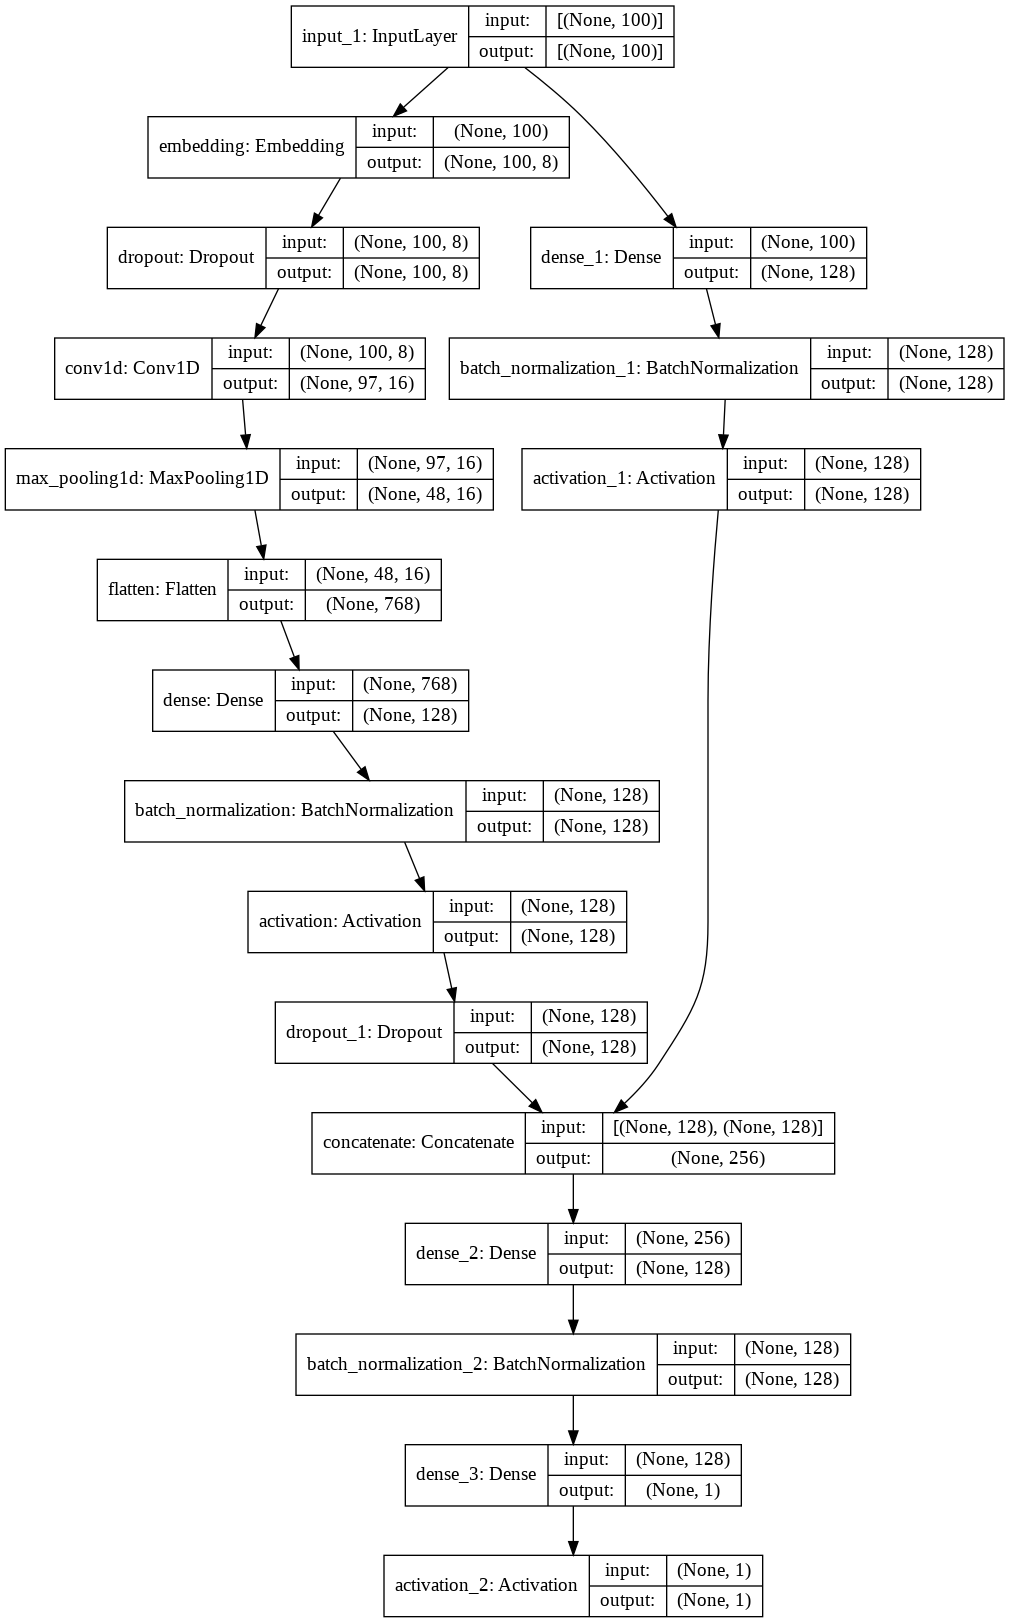

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.optimizers import Adam

adam = Adam(learning_rate=1e-5)

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train_seq_trunc,y_train, epochs=100, validation_data=(X_val_seq_trunc,y_val))

Epoch 1/100
1763/1763 [==============================] - 14s 7ms/step - loss: 0.6160 - accuracy: 0.6716 - val_loss: 0.5921 - val_accuracy: 0.6941
Epoch 2/100
1763/1763 [==============================] - 13s 7ms/step - loss: 0.6097 - accuracy: 0.6796 - val_loss: 0.5848 - val_accuracy: 0.7032
Epoch 3/100
1763/1763 [==============================] - 13s 7ms/step - loss: 0.6069 - accuracy: 0.6843 - val_loss: 0.5792 - val_accuracy: 0.7098
Epoch 4/100
1763/1763 [==============================] - 13s 7ms/step - loss: 0.6045 - accuracy: 0.6869 - val_loss: 0.5759 - val_accuracy: 0.7110
Epoch 5/100
1763/1763 [==============================] - 13s 7ms/step - loss: 0.5955 - accuracy: 0.6951 - val_loss: 0.5707 - val_accuracy: 0.7164
Epoch 6/100
1763/1763 [==============================] - 13s 7ms/step - loss: 0.6006 - accuracy: 0.6928 - val_loss: 0.5672 - val_accuracy: 0.7209
Epoch 7/100
1763/1763 [==============================] - 13s 7ms/step - loss: 0.5930 - accuracy: 0.6973 - val_loss: 0.5638 -

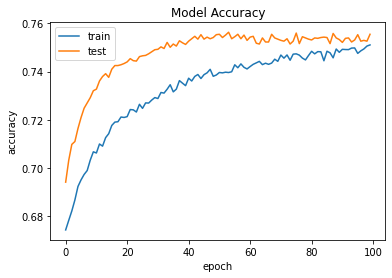

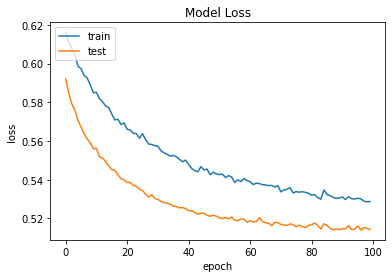

In [ ]:
# Model Outputs

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()